In [1]:
from torch.utils.data import DataLoader
from data_analysis_utils import *
from data_analysis_utils import model
from pathlib import Path

checkpoint_path = Path('/data/condor_shared/users/ssued/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/experiments/exp_RNO_four_2_1_0_linear_bn128_tr495_te124_lfn-MSELoss_opt-Adam_hiddenu-32_lr-0.001_lFactor-0.1_batchnorm-True_cartesian_transform-True/checkpoints')
album_path = '/data/i3store/users/ssued/albums/RNO_album_11_03_2025_20k_unorm/album_RNO4.hdf5'

# album_normalization_factor = [0.494392067193985,1230.7686767578125,15.53587818145752,1235.851318359375,-852.8795166015625,445.83966064453125]

album = AlbumDataset(album_path, transform = None, target_transform=spher_to_cart,normalize_labels=True,normalization_factors=[0.494392067193985,1230.7686767578125,15.53587818145752,1235.851318359375,-852.8795166015625,445.83966064453125])
data_loader = DataLoader(dataset = album, batch_size = 1, shuffle = True)

test_model = model.RNO_four_2_1_0_linear(input_shape=1,
                          hidden_units=32,
                          normalize_inputs=True,
                          leak_factor=0.1,
                          output_shape=3,
                          num_epochs=1,
                          batch_size=1,
                          num_train_batches=1
                         )

model_results = ModelEval(test_model,album,data_loader,checkpoint_path=checkpoint_path,num_samples=100)

/data/condor_shared/users/ssued/mlvenv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/data/condor_shared/users/ssued/mlvenv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happ

Utilizing inputted normalization statistics
  r:     mean=0.4944, std=1230.7687
  theta: mean=15.5359, std=1235.8513
  phi:   mean=-852.8795, std=445.8397
[0.494392067193985,1230.7686767578125,15.53587818145752,1235.851318359375,-852.8795166015625,445.83966064453125]
Calculating linear layer size using dummy shape: torch.Size([1, 1, 24, 1024, 4])
Flattened feature size: 9920
Creating Linear Layer: 9920 -> 3
Checkpoint path provided is a directory: /data/condor_shared/users/ssued/machine_learning/vertices_RNO4/model_cutoff_dataset_unnorm_labels_cartesian/experiments/exp_RNO_four_2_1_0_linear_bn128_tr495_te124_lfn-MSELoss_opt-Adam_hiddenu-32_lr-0.001_lFactor-0.1_batchnorm-True_cartesian_transform-True/checkpoints
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


# Test what happens to the model if inputted a completely empty image

In [ ]:
import torch

# Create a fake "empty" event
dummy_zero = torch.zeros((1, 1, 24, 1024, 4))

# Run model
with torch.no_grad():
    prediction = test_model(dummy_zero)

# Denormalize (if your model outputs Z-scores)
real_prediction = album.denormalize_label(prediction.cpu().numpy())

print("Model Output for Empty Input:", real_prediction)

# Inherent bias!!

Model Output for Empty Input: tensor([[ 651.1508,  677.4012, -820.1268]])


Found 19 checkpoints to evaluate.

--- Evaluating Checkpoint: checkpoint_e50.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


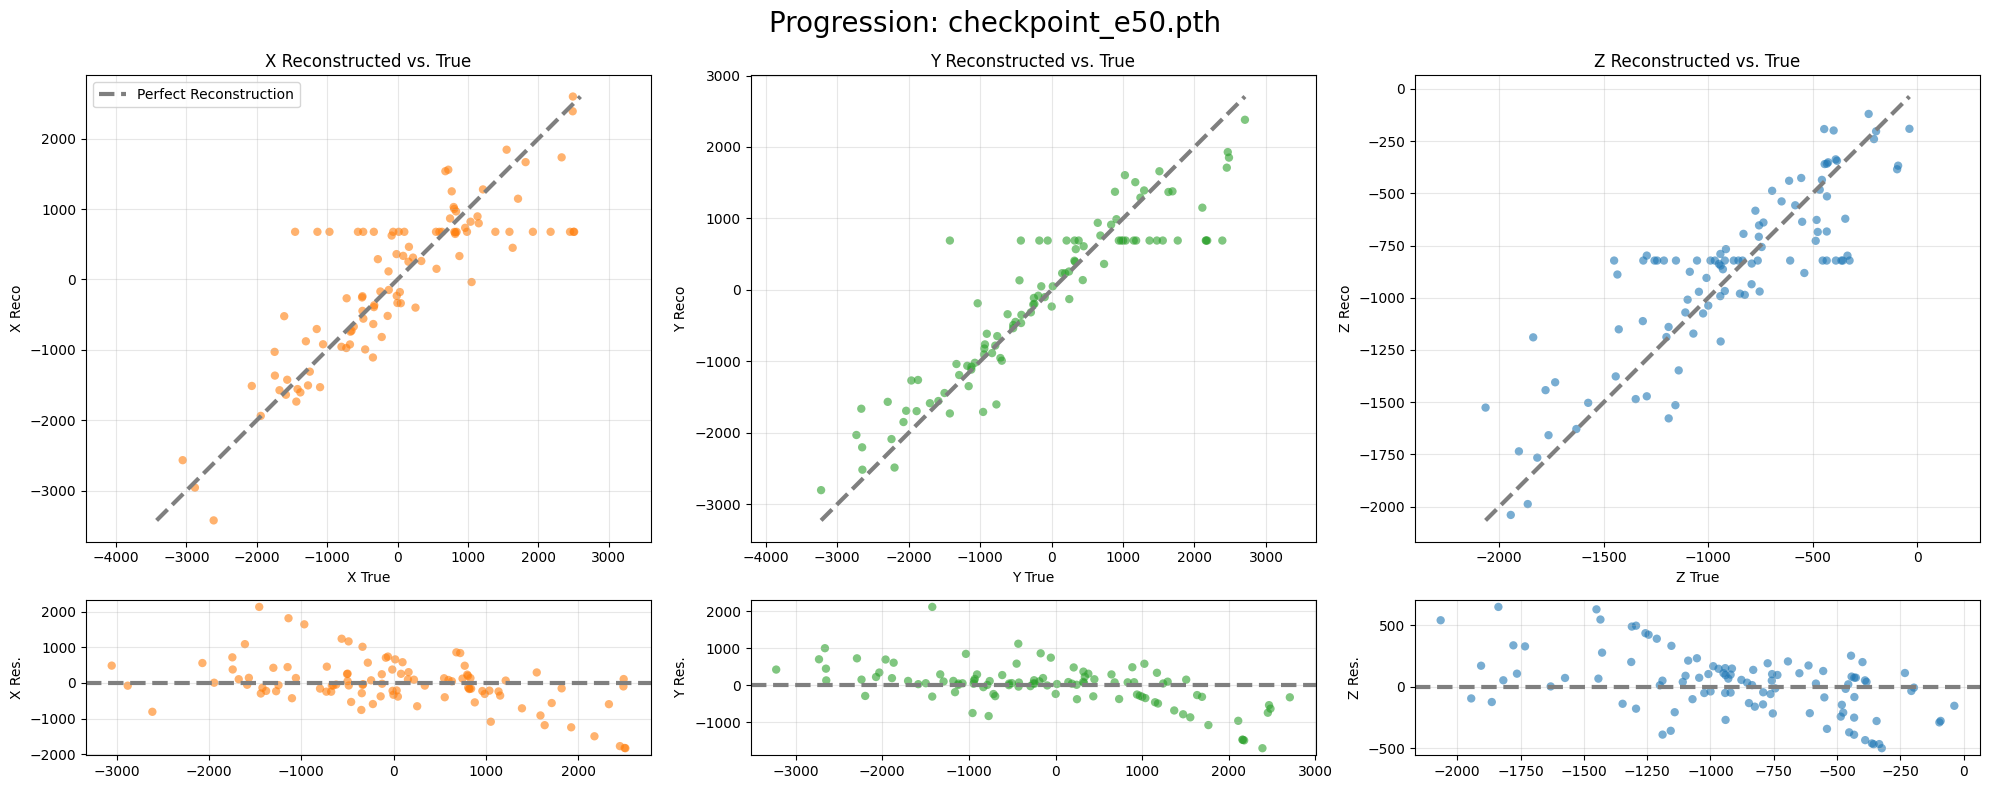


--- Evaluating Checkpoint: checkpoint_e100.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


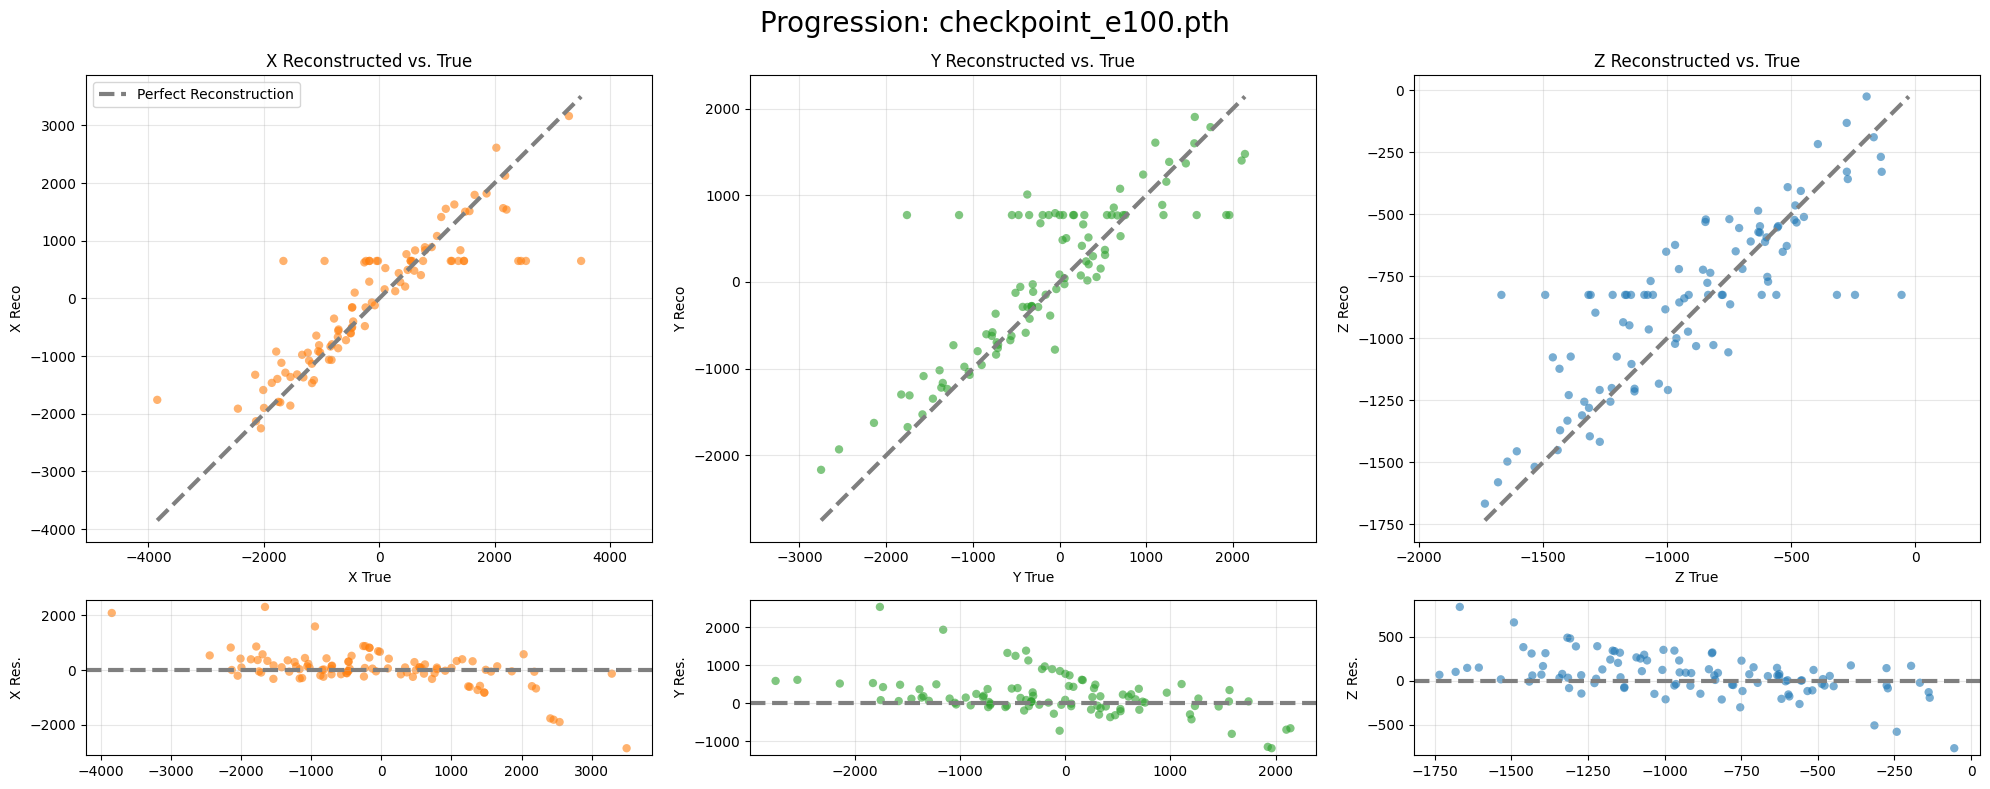


--- Evaluating Checkpoint: checkpoint_e150.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


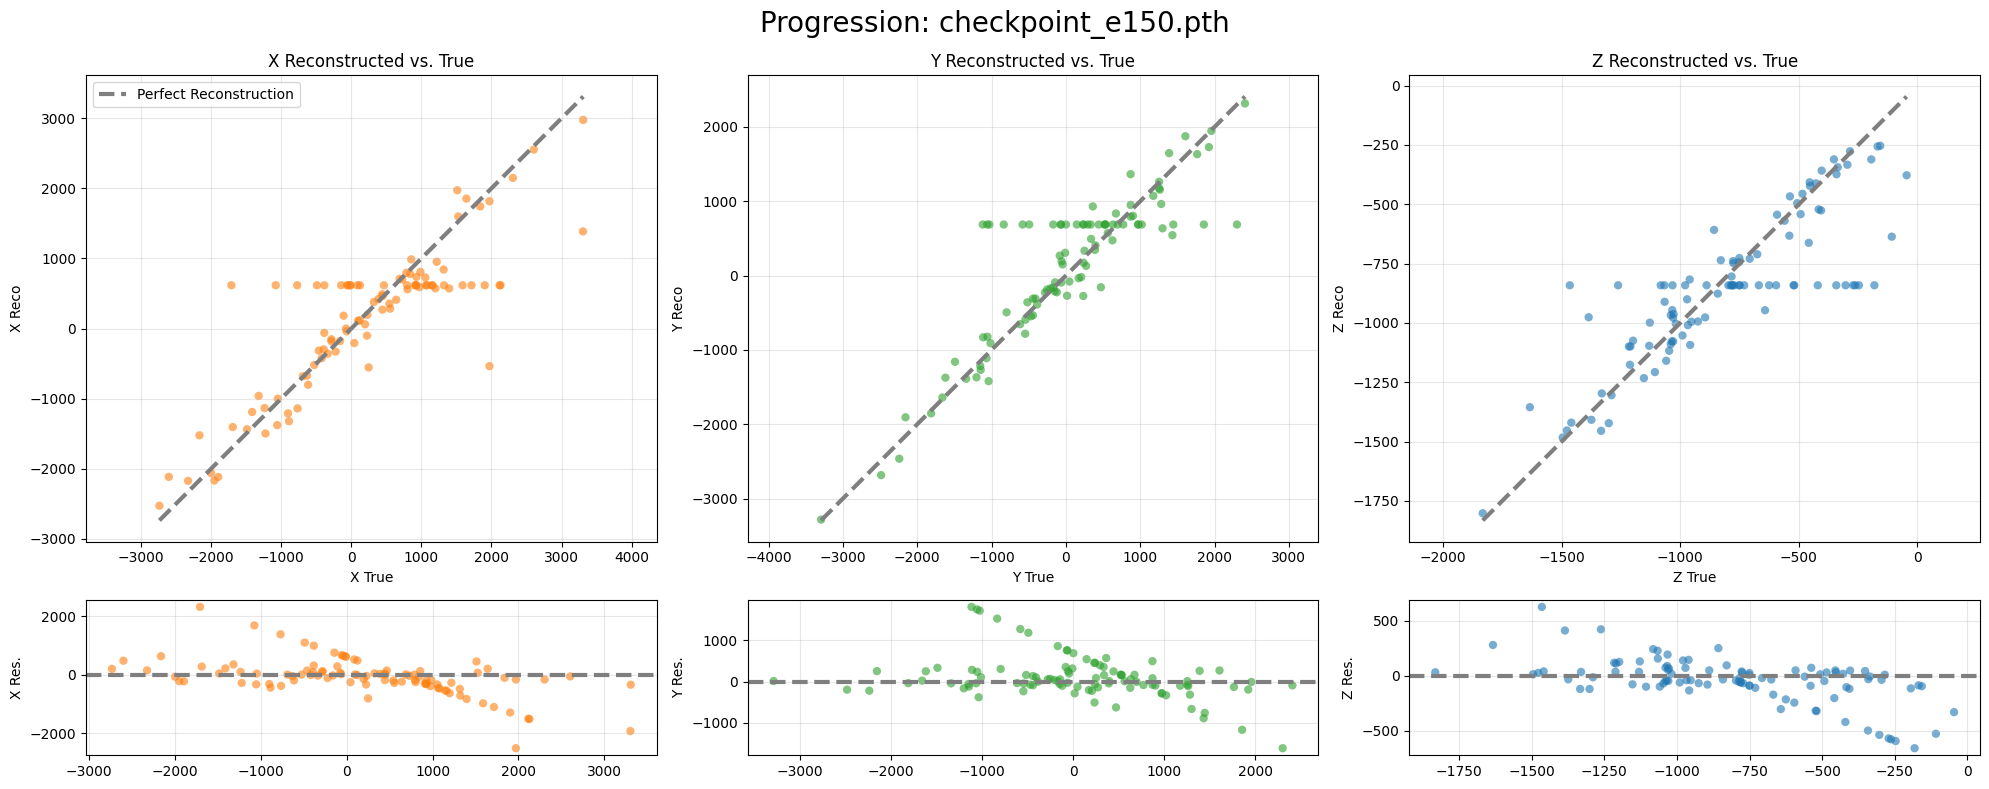


--- Evaluating Checkpoint: checkpoint_e200.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


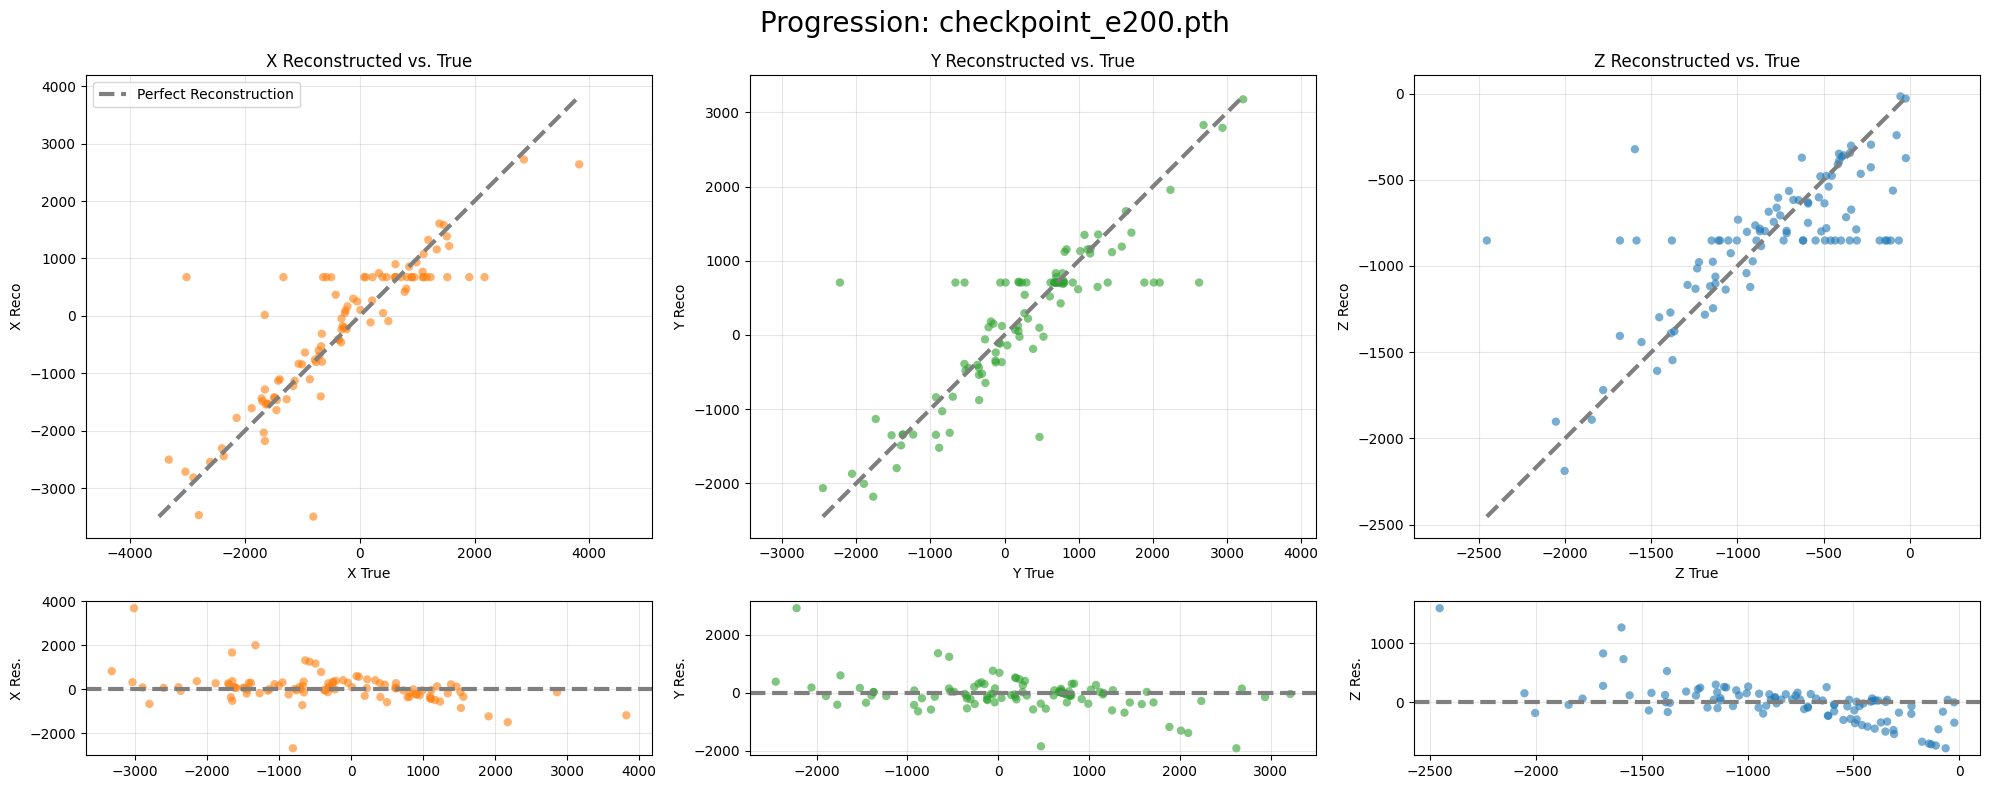


--- Evaluating Checkpoint: checkpoint_e250.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


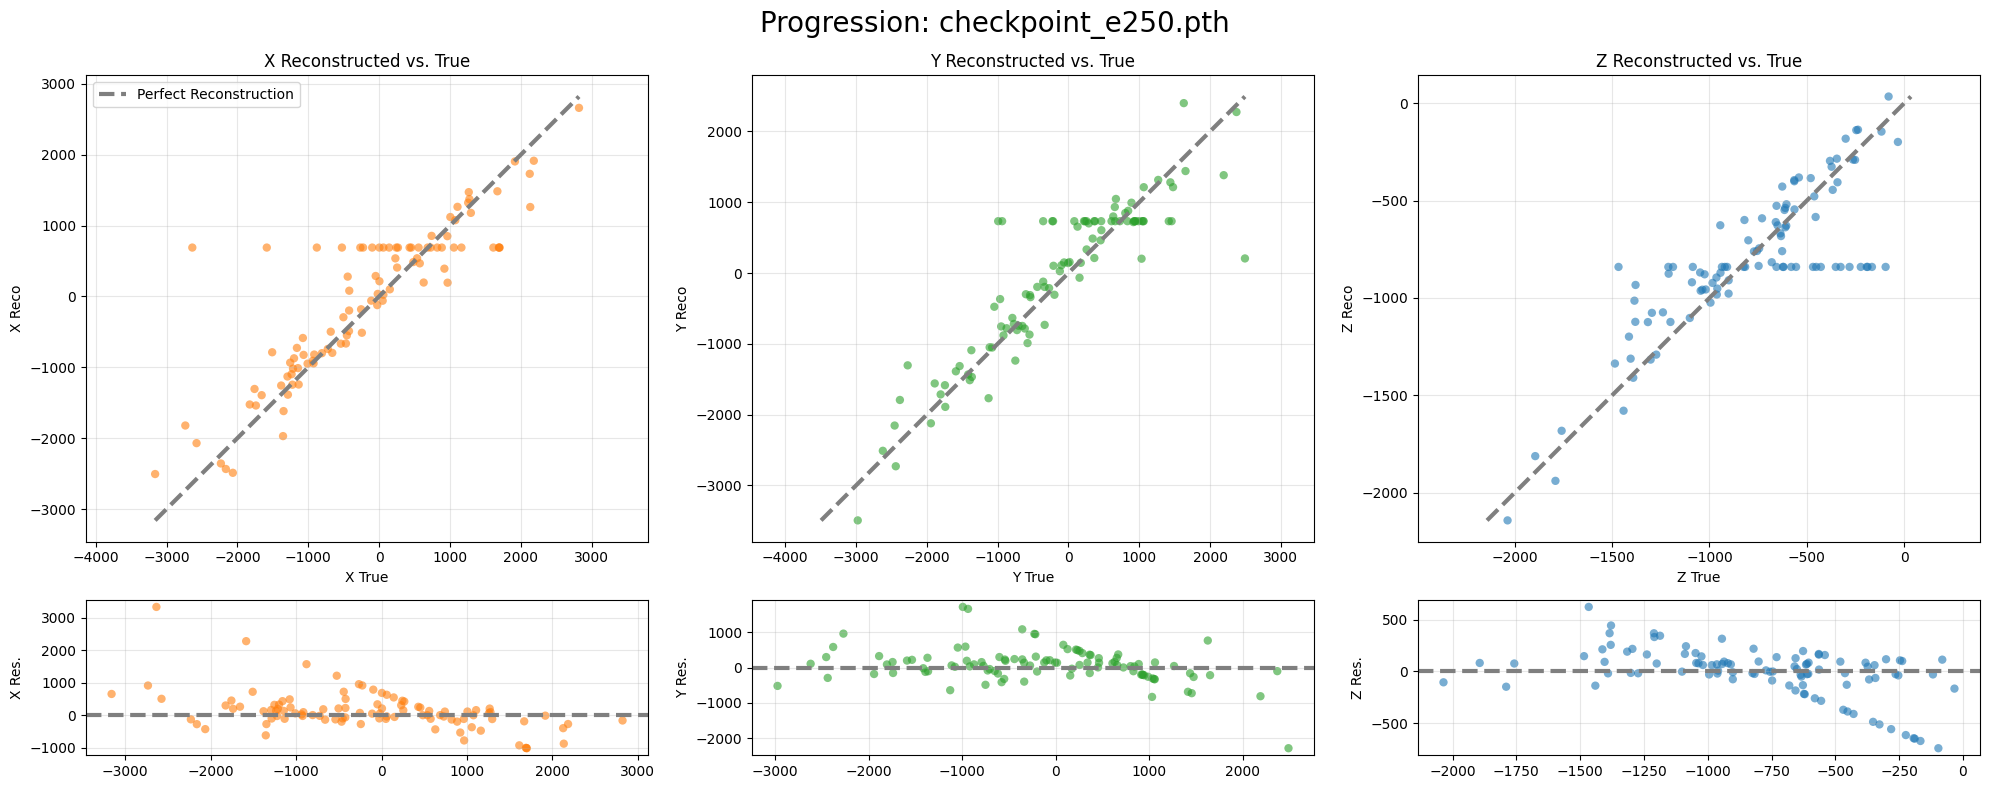


--- Evaluating Checkpoint: checkpoint_e300.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


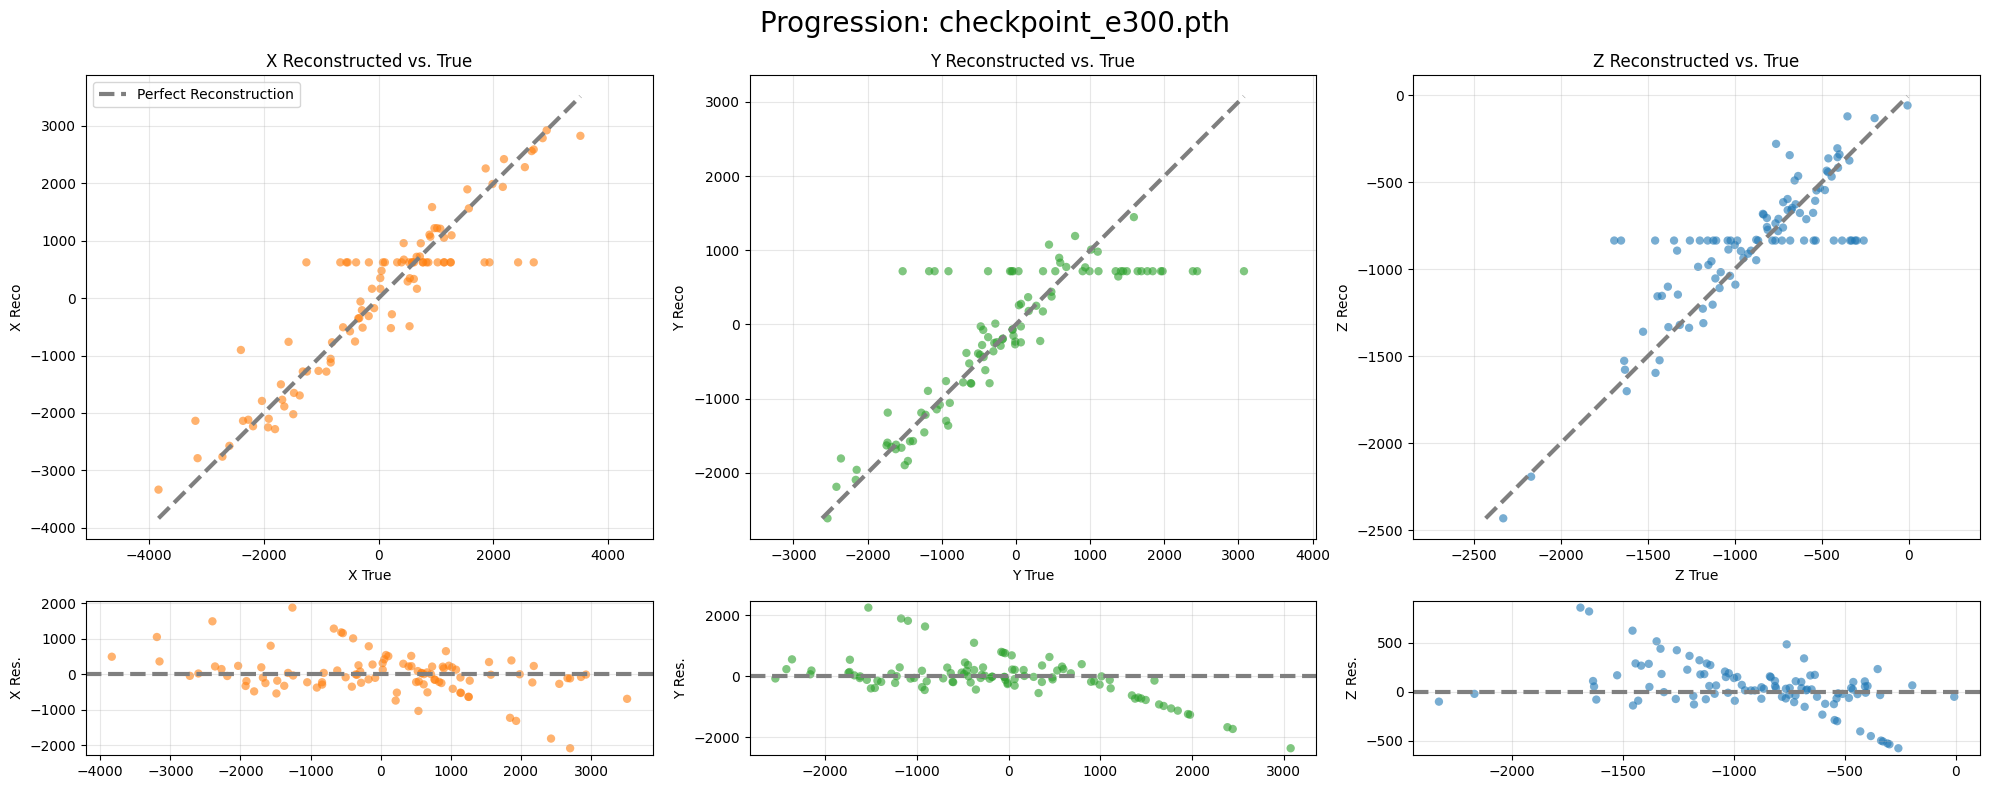


--- Evaluating Checkpoint: checkpoint_e350.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


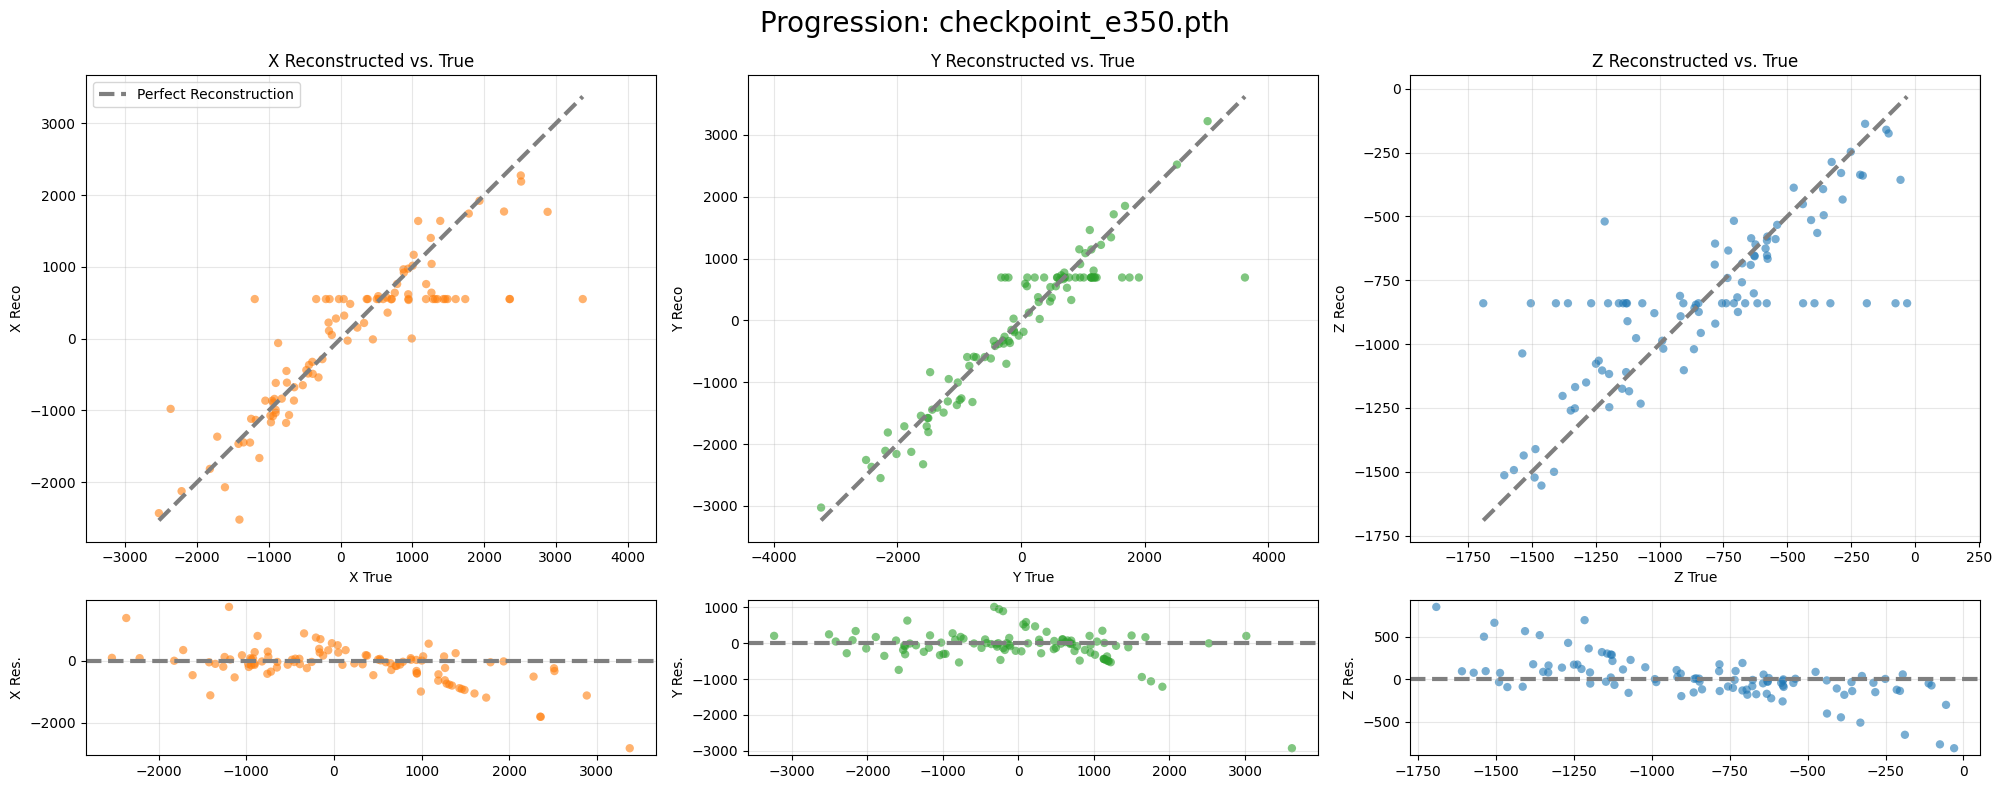


--- Evaluating Checkpoint: checkpoint_e400.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


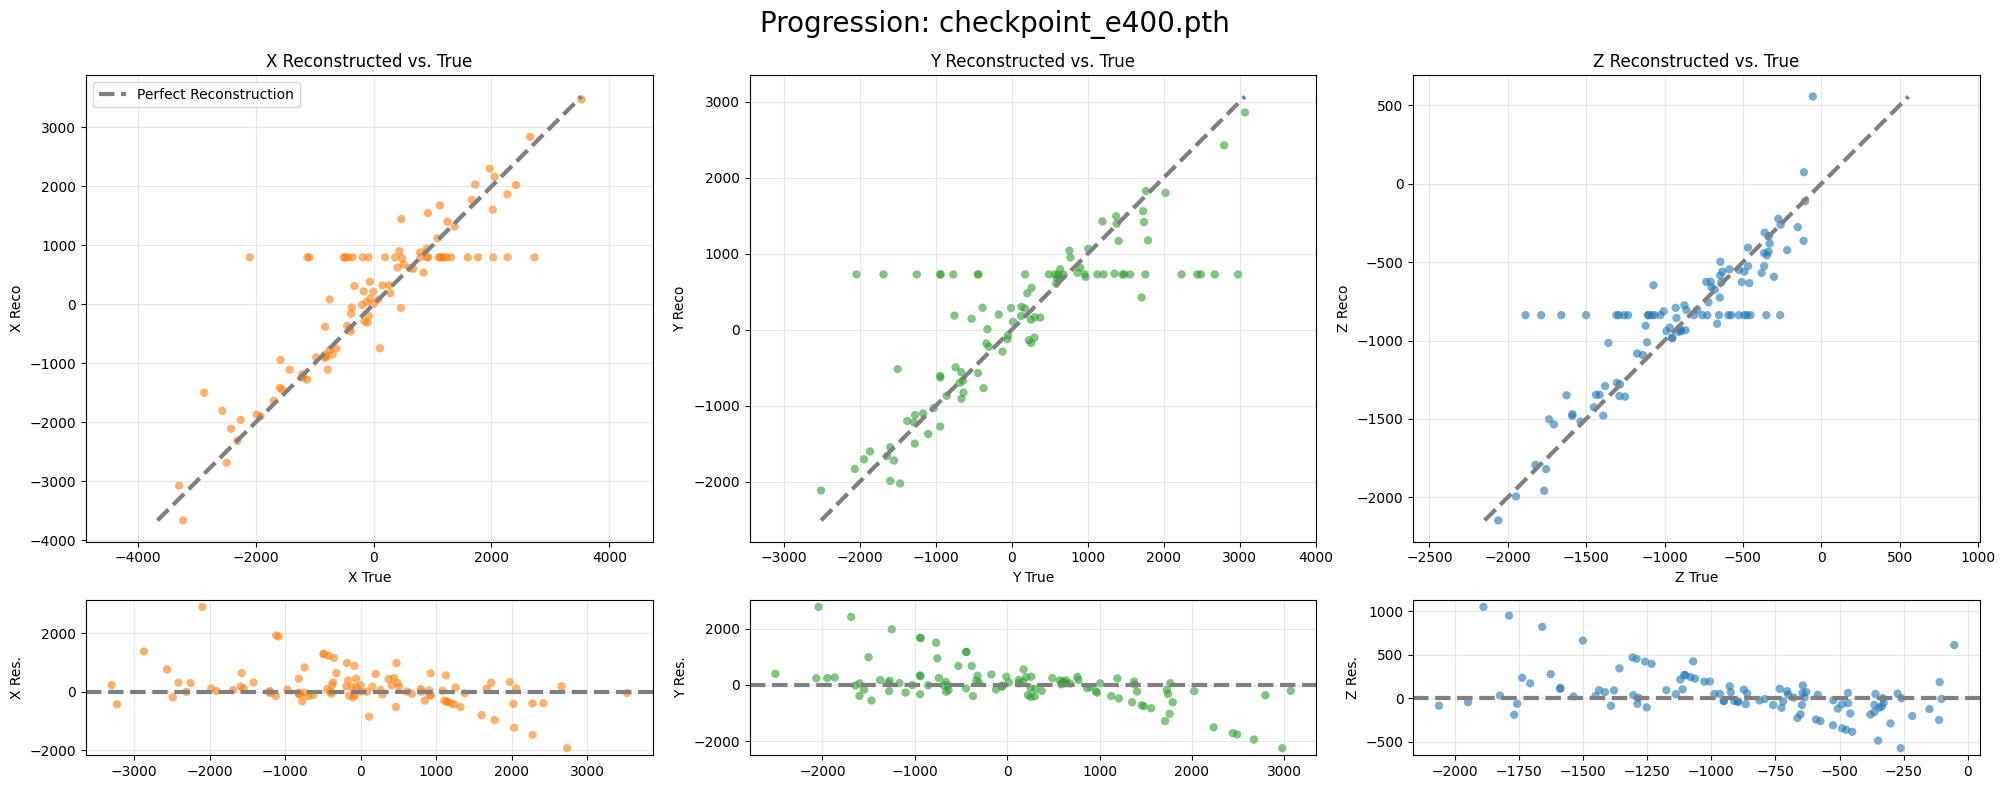


--- Evaluating Checkpoint: checkpoint_e450.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


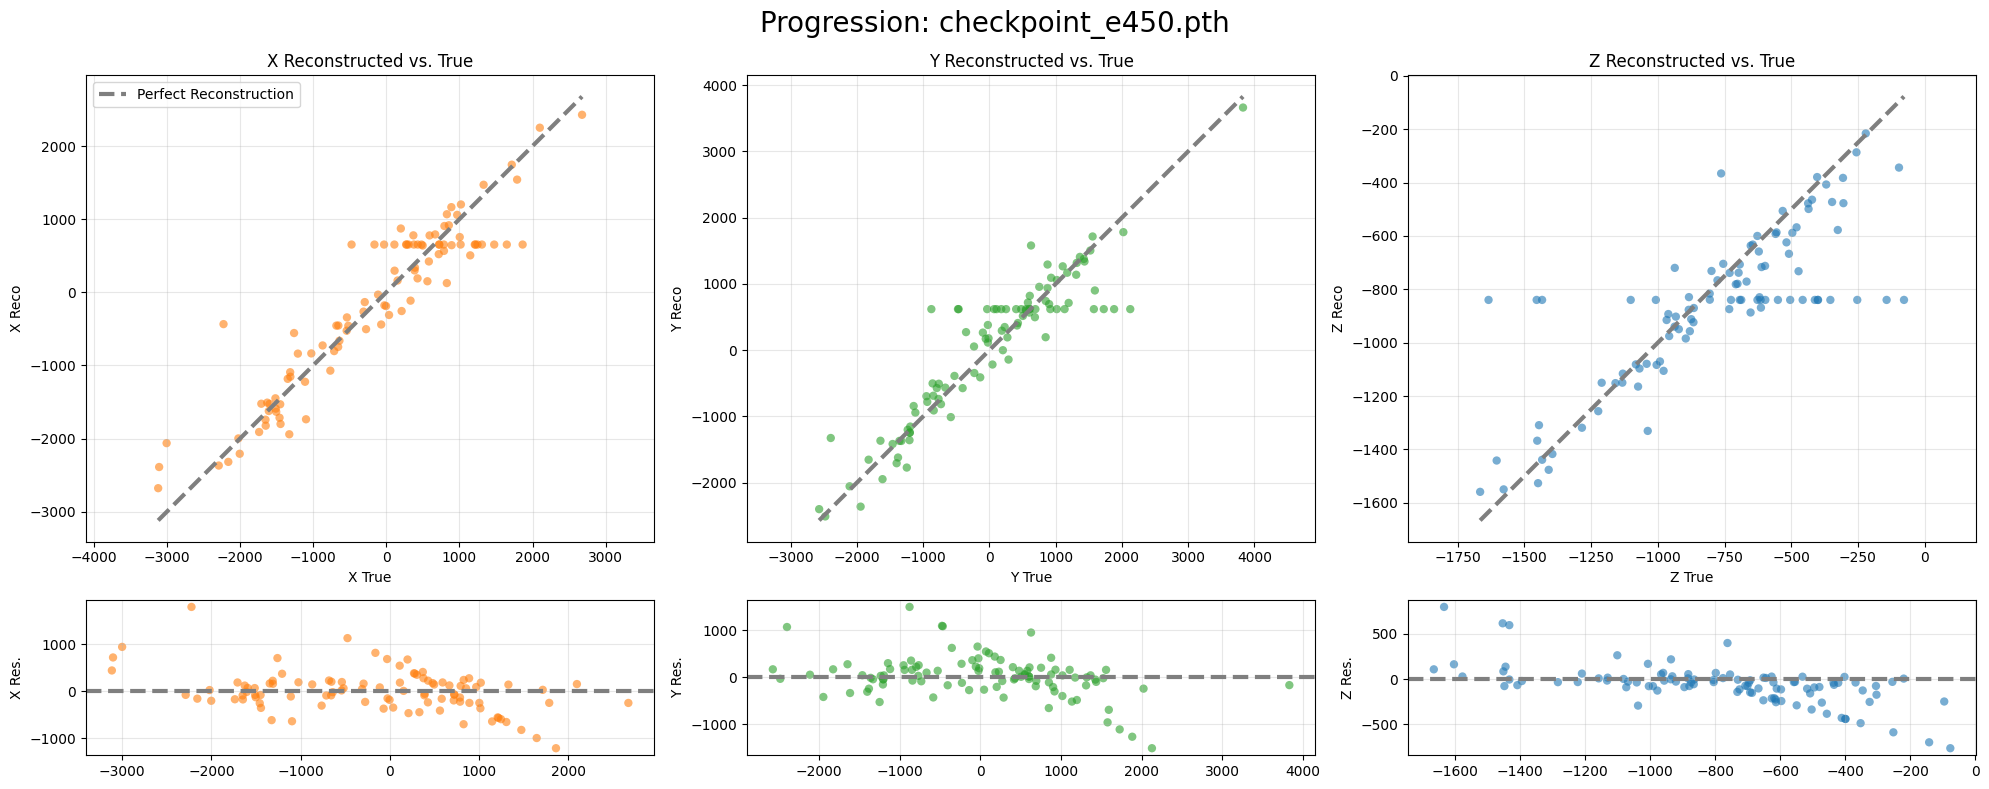


--- Evaluating Checkpoint: checkpoint_e500.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


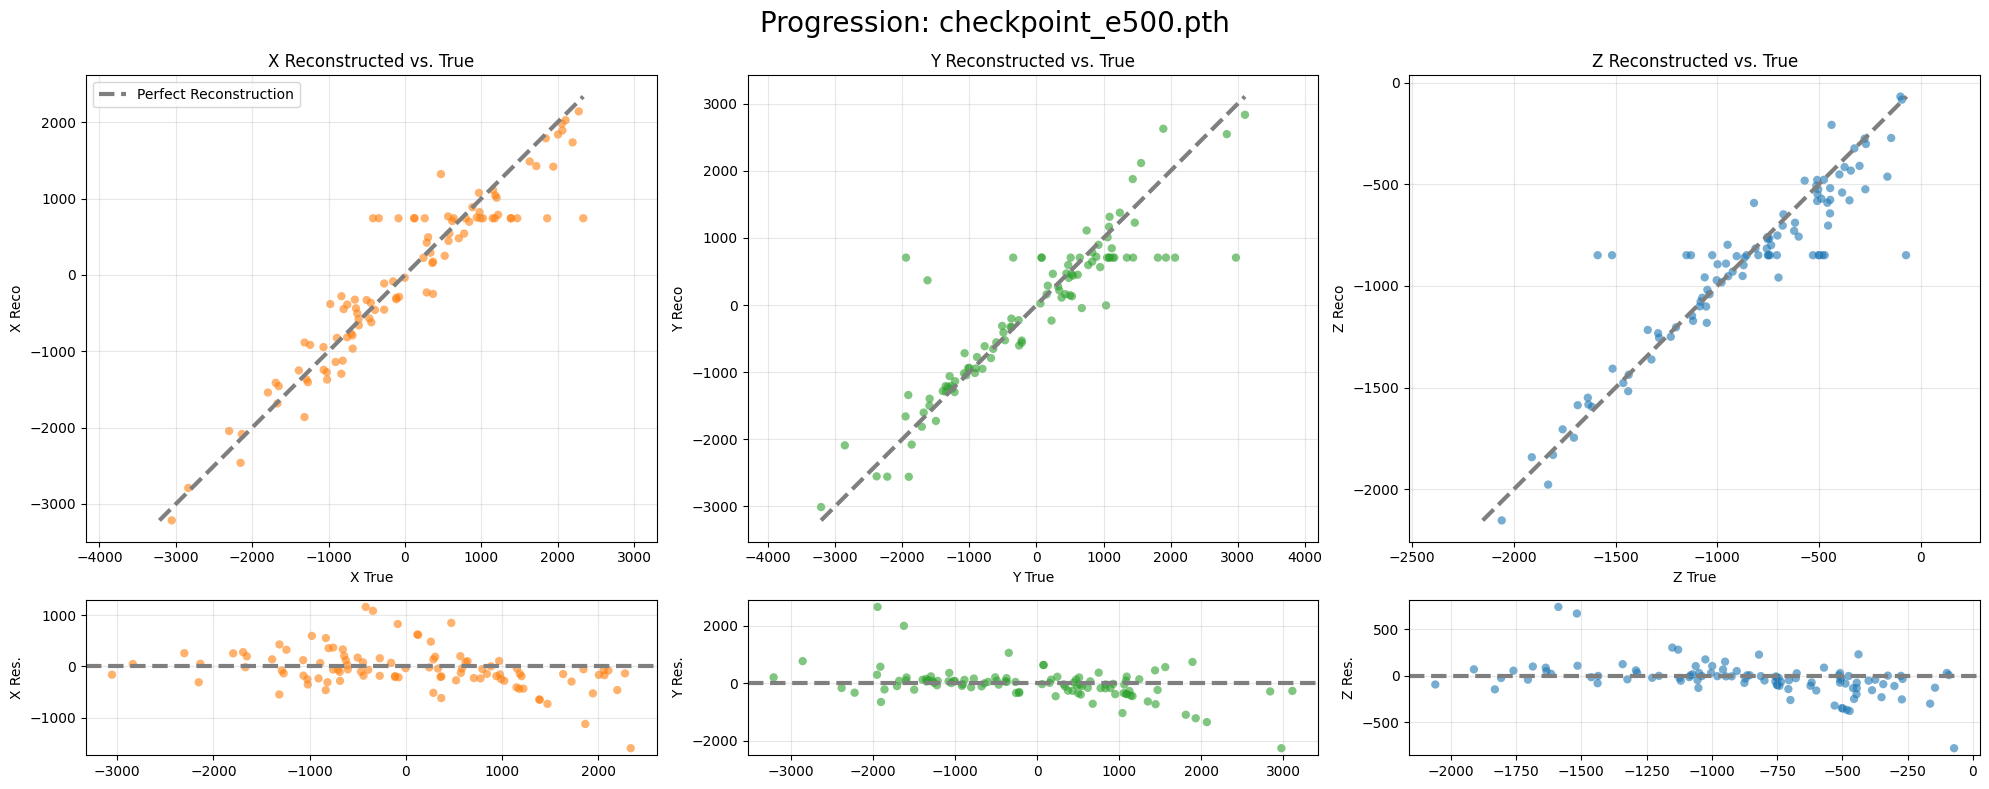


--- Evaluating Checkpoint: checkpoint_e550.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


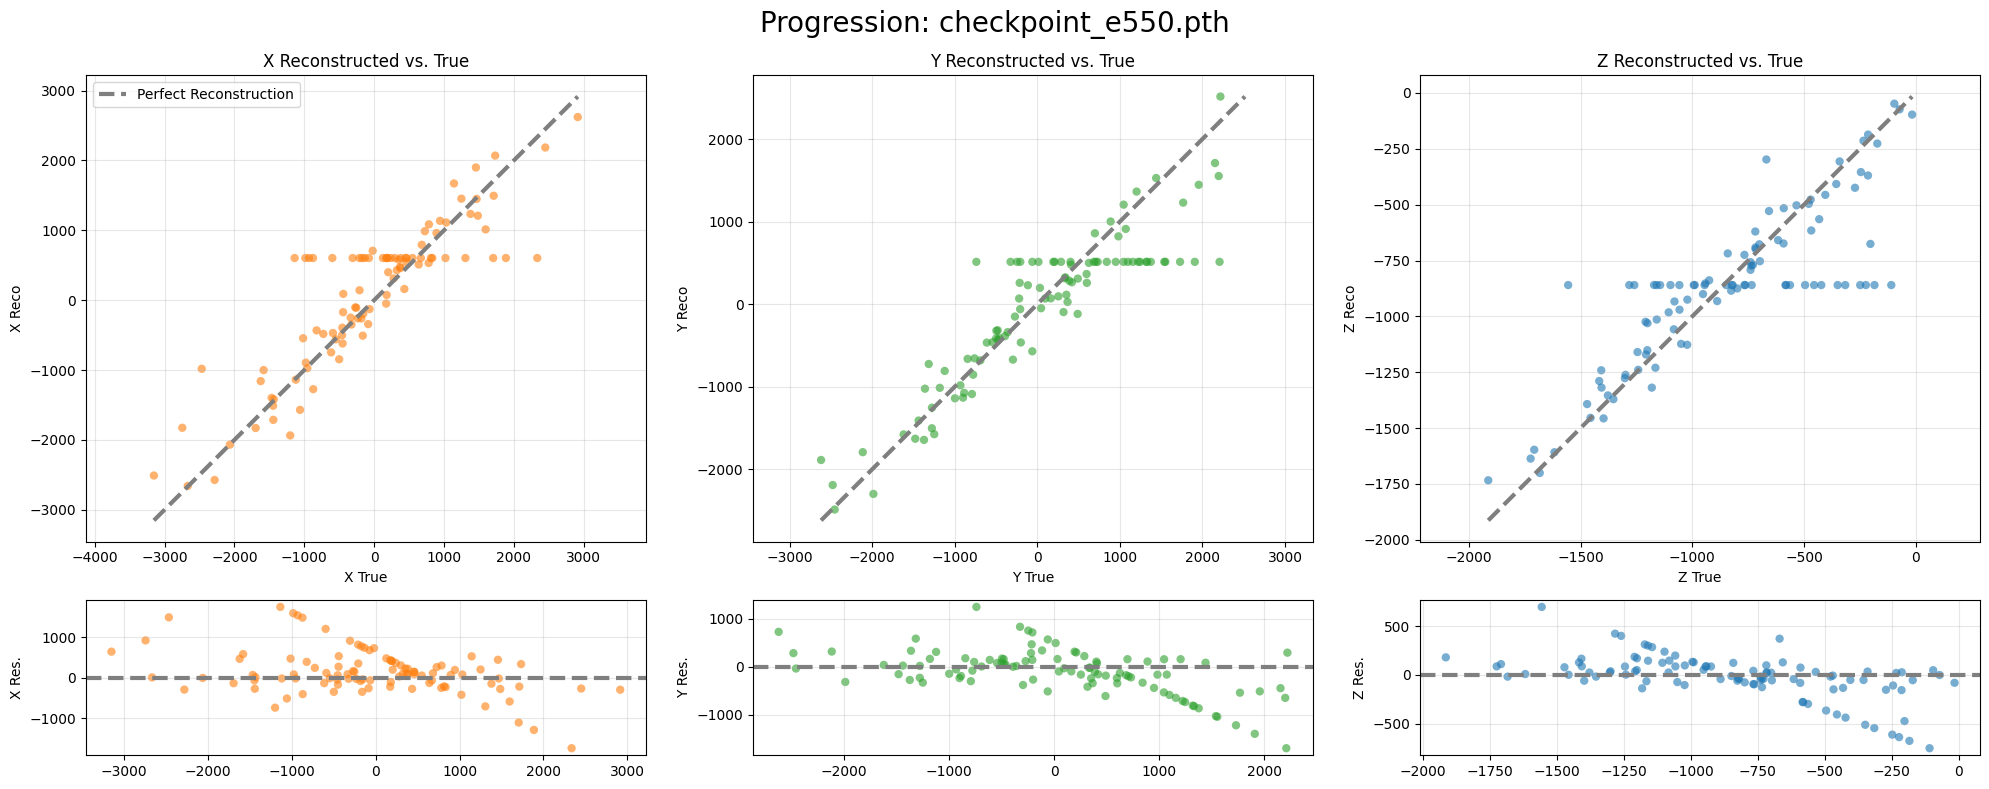


--- Evaluating Checkpoint: checkpoint_e600.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (100/100 samples)


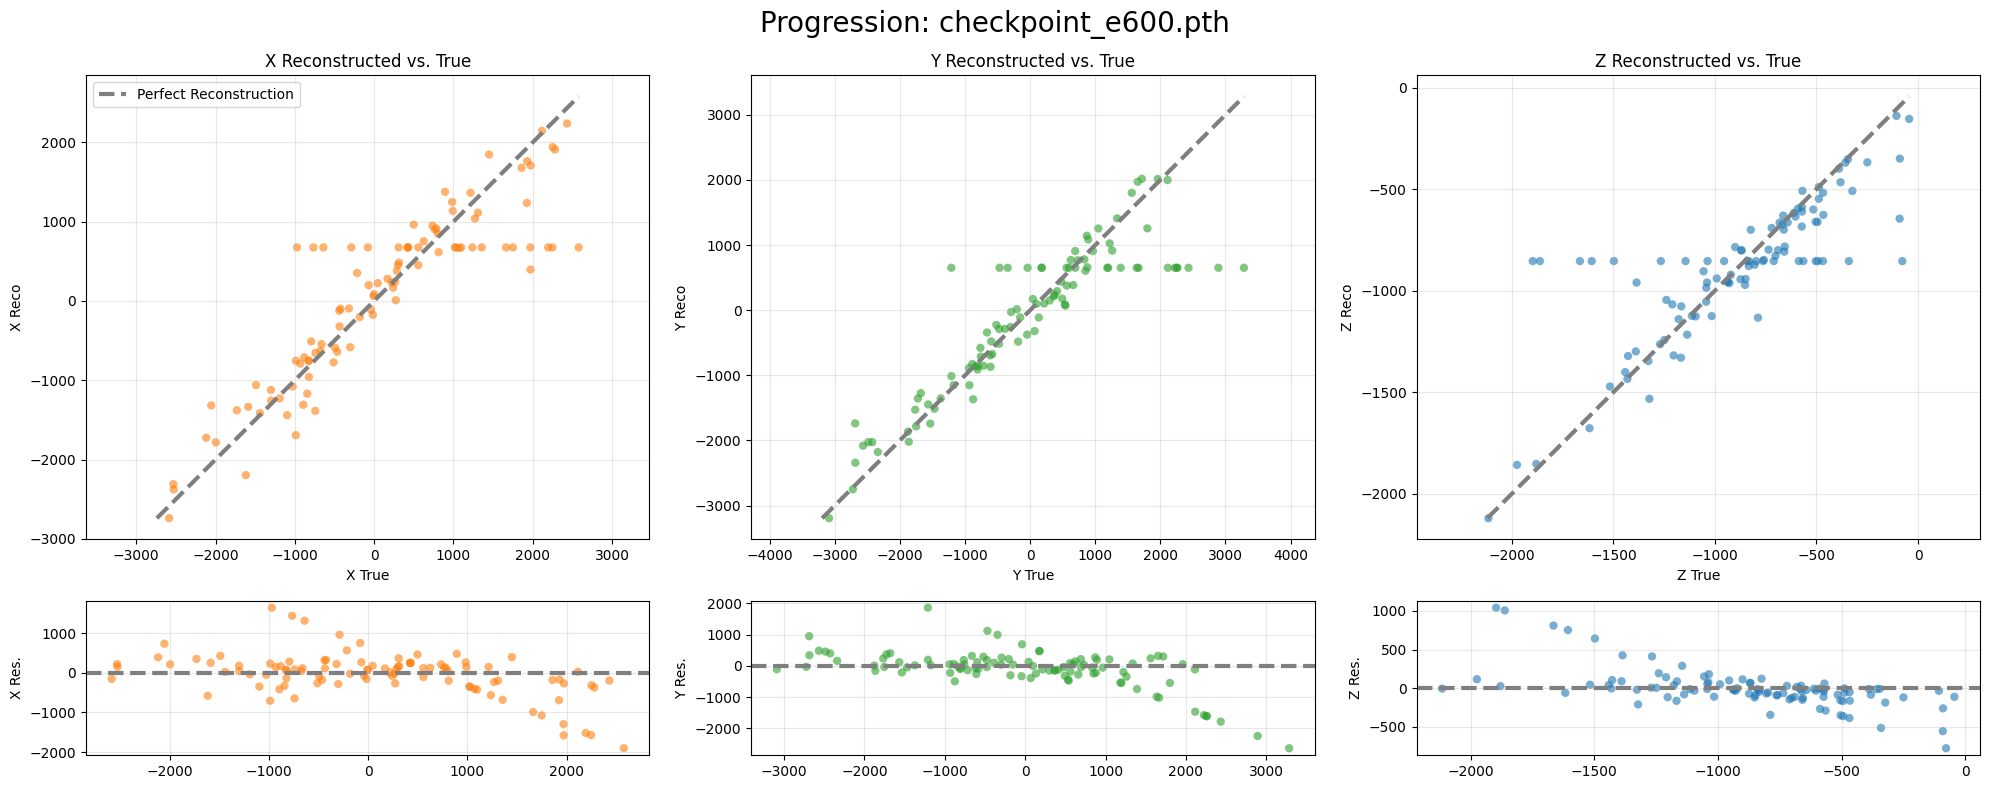


--- Evaluating Checkpoint: checkpoint_e650.pth ---
Guesses and targets will be denormalized during processing.
Testing Model... (48/100 samples)

KeyboardInterrupt: 

In [ ]:
model_results.plot_progression_true_reco(spherical=True)